In [1]:
from brightway2 import *
from bw2analyzer import *
from bw2regional import *
import csv

In [2]:
# Install through conda
import geopandas as gpd
import pandas as pd
import numpy as np
# import folium

In [3]:
projects.set_current("LC IMPACT case study")

In [4]:
sorted(geocollections)

['RoW',
 'ecoinvent',
 'ecoregions',
 'maize_landuse_intensity',
 'maize_water_intensity',
 'particulate-matter',
 'sugarcane_landuse_intensity',
 'sugarcane_water_intensity',
 'watersheds-eq-sw-core',
 'watersheds-eq-sw-extended',
 'watersheds-hh',
 'weighted-pop-density',
 'world',
 'world-topo-ecoregions',
 'world-topo-particulate-matter',
 'world-topo-watersheds-eq-sw-core',
 'world-topo-watersheds-eq-sw-extended',
 'world-topo-watersheds-hh']

In [5]:
for act in Database("Fuel comparison"):
    print(act.key, act)

('Fuel comparison', 'petrol transport') 'Driving with petrol' (kilometer, ('ecoinvent', 'RER'), None)
('Fuel comparison', 'sugarcane transport') 'Driving with sugarcane' (kilometer, ('ecoinvent', 'RER'), None)
('Fuel comparison', 'ethanol driving without fuel') 'ethanol driving without fuel' (kilometer, ('ecoinvent', 'RER'), None)
('Fuel comparison', 'maize transport') 'Driving with maize' (kilometer, ('ecoinvent', 'RER'), None)
('Fuel comparison', 'maize') 'Maize ethanol in europe' (kilogram, ('ecoinvent', 'RER'), None)
('Fuel comparison', 'sugarcane') 'Sugarcane ethanol in europe' (kilogram, ('ecoinvent', 'RER'), None)


In [ ]:
[x for x in methods if x[0] == 'LC-IMPACT']

In [4]:
irrigation = [x for x in Database("ecoinvent") if 'irrigation' in x['name']]
crops = [x for x in Database("ecoinvent") if (
    'sugarcane production' == x['name'] or 
    'maize grain production' == x['name']
)]

In [5]:
activities = [
    ('Fuel comparison', 'sugarcane transport'),
    ('Fuel comparison', 'maize transport'),
    ('Fuel comparison', 'petrol transport'),
]

lcimpact = {
 ("LC-IMPACT", "Climate Change", "Human Health", "Marginal", "Certain", "100 Years"): None,
 ("LC-IMPACT", "Climate Change", "Human Health", "Marginal", "All", "100 Years"): None,
 ("LC-IMPACT", "Climate Change", "Human Health", "Marginal", "Certain", "Infinite"): None,
 ("LC-IMPACT", "Climate Change", "Human Health", "Marginal", "All", "Infinite"): None,
 ("LC-IMPACT", "Climate Change", "Terrestrial Ecosystems", "Marginal", "Certain", "100 Years"): None,
 ("LC-IMPACT", "Climate Change", "Terrestrial Ecosystems",  "Marginal", "All", "100 Years"): None,
 ("LC-IMPACT", "Climate Change", "Terrestrial Ecosystems",  "Marginal", "Certain", "Infinite"): None,
 ("LC-IMPACT", "Climate Change", "Terrestrial Ecosystems",  "Marginal", "All", "Infinite"): None,
 ("LC-IMPACT", "Climate Change", "Aquatic Ecosystems", "Marginal", "All", "100 Years"): None,
 ("LC-IMPACT", "Climate Change", "Aquatic Ecosystems",  "Marginal", "All", "Infinite"): None, 
 ('LC-IMPACT', 'Land Use', 'Occupation', 'Marginal', 'Core'): {
     'xt others': 'world-topo-ecoregions-weighted-pop-density',
     'activities': crops,
     'sugarcane': 'world-topo-ecoregions-sugarcane_landuse_intensity',
     'maize': 'world-topo-ecoregions-maize_landuse_intensity',
 },
 ('LC-IMPACT', 'Particulate Matter Formation', 'Marginal', 'All'): {
     'xt others': 'world-topo-particulate-matter-weighted-pop-density',
     'activities': [],
     'sugarcane': 'world-topo-particulate-matter-sugarcane_landuse_intensity',
     'maize': 'world-topo-particulate-matter-maize_landuse_intensity',
 },
 ('LC-IMPACT', 'Particulate Matter Formation', 'Marginal', 'Certain'): {
     'xt others': 'world-topo-particulate-matter-weighted-pop-density',
     'activities': [],
     'sugarcane': 'world-topo-particulate-matter-sugarcane_landuse_intensity',
     'maize': 'world-topo-particulate-matter-maize_landuse_intensity',
 },
 ('LC-IMPACT', 'Water Use', 'Ecosystem Quality', 'Surface Water', 'Marginal', 'Extended uncertainty'): {
     'xt others': 'world-topo-watersheds-eq-sw-extended-weighted-pop-density',
     'activities': irrigation + crops,
     'sugarcane': 'world-topo-watersheds-eq-sw-extended-sugarcane_water_intensity',
     'maize': 'world-topo-watersheds-eq-sw-extended-maize_water_intensity',
 },
 ('LC-IMPACT', 'Water Use', 'Human Health', 'Marginal'): {
     'xt others': 'world-topo-watersheds-hh-weighted-pop-density',
     'activities': irrigation + crops,
     'sugarcane': 'world-topo-watersheds-hh-sugarcane_water_intensity',
     'maize': 'world-topo-watersheds-hh-maize_water_intensity',
 },
}

In [6]:
results = []

In [7]:
HEADERS = ["Name", "Unit", "Ref. product", "Location", "Score (absolute)", "Score (fraction of total)"]

In [8]:
for method, meta in lcimpact.items():
    print(method)
    results.append(list(method))
    
    fu = ('Fuel comparison', 'petrol transport')
    lca = LCA({fu: 1}, method)
    lca.lci()
    lca.lcia()
    
    results.append([])
    results.append(list(fu))
    results.append(["Site-generic score", lca.score])
    results.append(["Top 10 contributing activities"])
    results.append(HEADERS)
    for score, _, act in ContributionAnalysis().annotated_top_processes(lca)[:10]:
        results.append([act['name'], act['unit'], act['reference product'], act['location'], score, score / lca.score])

    if method[1] != 'Climate Change':        
        xt = ExtensionTablesLCA(
            {fu: 1},
            method,
            xtable=meta['xt others']
        )
        xt.lci()
        xt.lcia()

        results.append([])
        results.append(["Site-dependent score", xt.score])
        results.append(["Top 10 contributing activities"])
        results.append(HEADERS)
        for score, _, act in ContributionAnalysis().annotated_top_processes(xt)[:10]:
            results.append([act['name'], act['unit'], act['reference product'], act['location'], score, score / xt.score])

    for fu, crop in (
            (('Fuel comparison', 'sugarcane transport'), 'sugarcane'),
            (('Fuel comparison', 'maize transport'), 'maize'),
            ):
        
        lca = LCA({fu: 1}, method)
        lca.lci()
        lca.lcia()

        results.append([])
        results.append(list(fu))
        results.append(["Site-generic score", lca.score])
        results.append(["Top 10 contributing activities"])
        results.append(HEADERS)
        for score, _, act in ContributionAnalysis().annotated_top_processes(lca)[:10]:
            results.append([act['name'], act['unit'], act['reference product'], act['location'], score, score / lca.score])

        if method[1] != 'Climate Change':        
            if meta['activities']:
                xt_ag = ExtensionTablesLCA(
                    {fu: 1},
                    method,
                    xtable=meta['sugarcane'],
                    limitations={
                        'activities': meta['activities'],
                    }
                )
                xt_ag.lci()
                xt_ag.lcia()

                xt_others = ExtensionTablesLCA(
                    {fu: 1},
                    method,
                    xtable=meta['xt others'],
                    limitations={
                        'activities': meta['activities'],
                        'activities mode': 'exclude'
                    }
                )
                xt_others.lci()
                xt_others.lcia()

                total = xt_ag.score + xt_others.score

                results.append([])
                results.append(["Site-dependent score", total])
                results.append(["Top 10 contributing activities"])
                results.append(HEADERS)

                contributors = sorted((
                    ContributionAnalysis().annotated_top_processes(xt_ag)[:10] +         
                    ContributionAnalysis().annotated_top_processes(xt_others)[:10]        
                ), reverse=True)[:10]

                for score, _, act in contributors:
                    results.append([act['name'], act['unit'], act['reference product'], act['location'], score, score / total])

            else:
                xt = ExtensionTablesLCA(
                    {fu: 1},
                    method,
                    xtable=meta['xt others']
                )
                xt.lci()
                xt.lcia()

                results.append([])
                results.append(["Site-dependent score", xt.score])
                results.append(["Top 10 contributing activities"])
                results.append(HEADERS)
                for score, _, act in ContributionAnalysis().annotated_top_processes(xt)[:10]:
                    results.append([act['name'], act['unit'], act['reference product'], act['location'], score, score / xt.score])

    results.append([])
    results.append([])

('LC-IMPACT', 'Climate Change', 'Human Health', 'Marginal', 'Certain', '100 Years')
('LC-IMPACT', 'Climate Change', 'Human Health', 'Marginal', 'All', '100 Years')
('LC-IMPACT', 'Climate Change', 'Human Health', 'Marginal', 'Certain', 'Infinite')
('LC-IMPACT', 'Climate Change', 'Human Health', 'Marginal', 'All', 'Infinite')
('LC-IMPACT', 'Climate Change', 'Terrestrial Ecosystems', 'Marginal', 'Certain', '100 Years')
('LC-IMPACT', 'Climate Change', 'Terrestrial Ecosystems', 'Marginal', 'All', '100 Years')
('LC-IMPACT', 'Climate Change', 'Terrestrial Ecosystems', 'Marginal', 'Certain', 'Infinite')
('LC-IMPACT', 'Climate Change', 'Terrestrial Ecosystems', 'Marginal', 'All', 'Infinite')
('LC-IMPACT', 'Climate Change', 'Aquatic Ecosystems', 'Marginal', 'All', '100 Years')
('LC-IMPACT', 'Climate Change', 'Aquatic Ecosystems', 'Marginal', 'All', 'Infinite')


In [9]:
with open("lcimpact-case-study.csv", "w") as f:
    writer = csv.writer(f)
    for row in results:
        writer.writerow(row)

# Calculate climate change scores

# Visualize sugarcane land use

In [9]:
# Do irrigation with the sugar land intensity map, all others with the weighted pop density map
xt_ag = ExtensionTablesLCA(
    {('Fuel comparison', 'sugarcane transport'): 1},
    ('LC-IMPACT', 'Land Use', 'Occupation', 'Marginal', 'Core'),
    xtable='world-topo-ecoregions-sugarcane_landuse_intensity',
    limitations={
        'activities': irrigation + crops,
    }
)
xt_ag.lci()
xt_ag.lcia()

xt_others = ExtensionTablesLCA(
    {('Fuel comparison', 'sugarcane transport'): 1},
    ('LC-IMPACT', 'Land Use', 'Occupation', 'Marginal', 'Core'),
    xtable='world-topo-ecoregions-weighted-pop-density',
    limitations={
        'activities': irrigation + crops,
        'activities mode': 'exclude'
    }
)
xt_others.lci()
xt_others.lcia()

xt_ag.score + xt_others.score

9.718523293494226e-14

In [10]:
xt_ag.fix_spatial_dictionaries()

In [56]:
def iterate_results_spatial_labels(matrix, axis, spatial_dict, cutoff=1e-2, as_string=False):
    def _(x):
        if isinstance(x, tuple):
            x = x[1]
        if as_string:
            x = str(x)
        return x
        
    rsd = {y: _(x) for x, y in spatial_dict.items()}

    total = matrix.sum()
    summed = np.array(matrix.sum(axis=axis)).ravel()
    sorting = np.argsort(np.abs(summed))[::-1]

    summed = summed[sorting]
    mask = summed > (cutoff * summed.max())

    for x, y in zip(summed[mask], sorting):
        yield x, x * 100 / total, rsd[y]

In [60]:
def to_geopandas(result_iter, geocollection):
    source = gpd.read_file(geocollections[geocollection]['filepath'])
    merged = source.merge(pd.DataFrame(
        list(result_iter), 
        columns=['lcia_weight', 'lcia_weight_normalized', geocollections[geocollection]['field']]
    ))
    return merged

In [16]:
df = to_geopandas(
    iterate_results_spatial_labels(
        (xt_ag.results_ia_spatial_scale() + xt_others.results_ia_spatial_scale()),
        0,
        xt_ag.ia_spatial_dict,
    ),
    'ecoregions'
)

In [17]:
%matplotlib inline

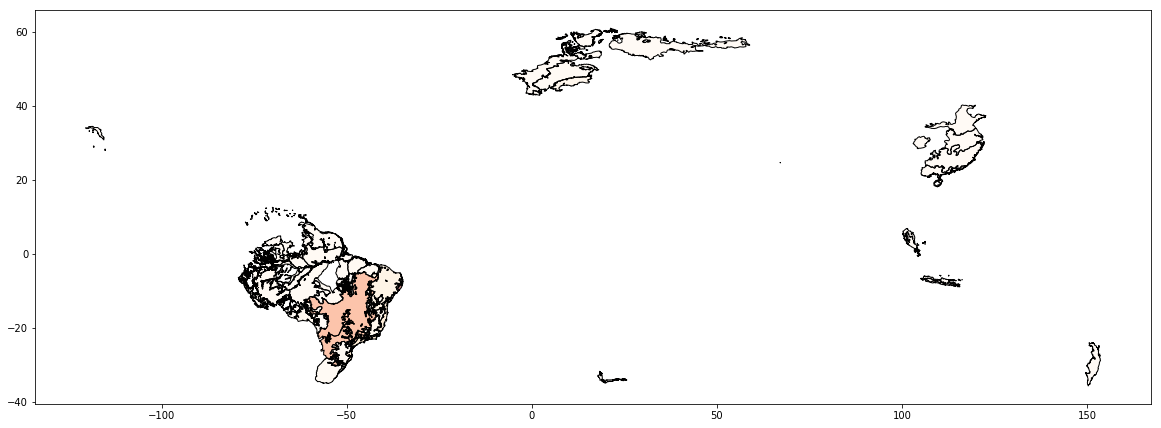

In [18]:
df.plot(column='lcia_weight_normalized', cmap='OrRd', figsize=(20, 15))

Interactive map using [folium](https://pypi.python.org/pypi/folium).

More foilum docs:

* http://python-visualization.github.io/folium/module/folium.html
* http://nbviewer.jupyter.org/github/ocefpaf/folium_notebooks/blob/master/test_image_overlay_gulf_stream.ipynb
* http://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/ImageOverlay.ipynb
* https://folium.readthedocs.io/en/latest/quickstart.html
* https://automating-gis-processes.github.io/2016/Lesson5-interactive-map-folium.html

In [19]:
m = folium.Map(location=[0, 0], zoom_start=2, 
               tiles="cartodbpositron")

df['geoid'] = df.index.astype(str)
geo_str = df.to_json()

m.choropleth(geo_str=geo_str,
             data=df, columns=['geoid', 'lcia_weight_normalized'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.4, line_opacity=0.2)
m

In [21]:
df.to_file("sugarcane_land_impact.geojson", driver='GeoJSON')

# Visualize maize water use

In [70]:
# Do irrigation with the maize water intensity map, all others with the weighted pop density map
xt_ag = ExtensionTablesLCA(
    {('Fuel comparison', 'maize transport'): 1},
     ('LC-IMPACT', 'Water Use', 'Ecosystem Quality', 'Surface Water', 'Marginal', 'Core uncertainty'),
    xtable='world-topo-watersheds-eq-sw-core-maize_water_intensity',
    limitations={
        'activities': irrigation + crops,
    }
)
xt_ag.lci()
xt_ag.lcia()

xt_others = ExtensionTablesLCA(
    {('Fuel comparison', 'maize transport'): 1},
    ('LC-IMPACT', 'Water Use', 'Ecosystem Quality', 'Surface Water', 'Marginal', 'Core uncertainty'),
    xtable='world-topo-watersheds-eq-sw-core-weighted-pop-density',
    limitations={
        'activities': irrigation + crops,
        'activities mode': 'exclude'
    }
)
xt_others.lci()
xt_others.lcia()

xt_ag.score + xt_others.score

1.006887471766816e-13

In [71]:
xt_ag.fix_spatial_dictionaries()

In [72]:
df = to_geopandas(
    iterate_results_spatial_labels(
        (xt_ag.results_ia_spatial_scale() + xt_others.results_ia_spatial_scale()),
        0,
        xt_ag.ia_spatial_dict,
    ),
    'watersheds-eq-sw-core',
)

In [73]:
m = folium.Map(location=[0, 0], zoom_start=2, 
               tiles="cartodbpositron")

df['geoid'] = df.index.astype(str)
geo_str = df.to_json()

m.choropleth(geo_str=geo_str,
             data=df, columns=['geoid', 'lcia_weight_normalized'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.4, line_opacity=0.2)
m

In [65]:
df.to_file("maize_water_eq_impact.geojson", driver='GeoJSON')